SUPERLATTICE XRD FITTING TOOL
-----------------------------------------------------------------------------------------------------------

-----------------------------------------------------------------------------------------------------------
PARAMETERS LEGEND.

Structural parameters:
- d: periodicity of the atomic planes generating the Bragg peaks, in Angstrom.
- L: interparticle spacing, in Angstrom.
- sigmaL: fluctuation of the interparticle spacing, in Angstrom.
- N: average nanocrystal thickness, in number of atomic planes. 
- sigmaN: standard deviation of the nanocrystal thickness, in number of atomic planes. 

Instrumental parameters:
- q_zero: a parameter that corrects imperfections in the diffractometer alignment. It should be small (< 0.1) and can be positive or negative.
- inst_broadening: standard deviation (of the gaussian fit) of the narrowest peak your instrument can measure. Should be estimated on a standard (e.g. LaB6).
- C: coherence length of the beam, expressed in number of nanocrystal layers. Should be set to a number high enough not to produce changes in the fit (see Chi-maps section below)
- assumed_error: describes the magnitude of fluctuations in the experimentally measured intensity. 

-----------------------------------------------------------------------------------------------------------
INITIALIZATION. 

Run this section first step to load libraries and modules

In [1]:
import numpy as np
from scipy import optimize
from scipy import signal
import scipy as sp
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
import sys

print('Numpy Version: ' + str(np.__version__))
print('Scipy Version: ' + str(sp.__version__))
print('Matplotlib Version: ' + str(mpl.__version__))
print('Pandas Version: ' + str(pd.__version__))
print('Python Version: ' + str(sys.version_info.major) + '.' + str(sys.version_info.minor) + '.' + str(sys.version_info.micro))

from Deconvolution import XRD_decon

Numpy Version: 1.18.5
Scipy Version: 1.5.0
Matplotlib Version: 3.2.2
Pandas Version: 1.0.5
Python Version: 3.8.3


If there are ImportErrors or NameErrors in the code that are unrelated to XRD_decon, it is possible that development of new python libraries has removed features this code relies on. Reverting to these versions should ensure that the code works: 

Numpy Version: 1.18.1 ; Scipy Version: 1.4.1 ; Matplotlib Version: 3.1.3 ; Pandas Version: 1.0.1 ; Python Version: 3.6.5

-----------------------------------------------------------------------------------------------------------
INPUT. 

Here you define:
- Experimental data file name (must be a double-column comma separated .csv file located in the same folder as the .ipynb file)
- Starting values and boundaries for the fittable parameters
- Instrumental parameters (inst_broadening, q_zero and coherence length)
- Of these, q_zero and C can be also set as fittable parameters
- q-range(s) over which to perform the fit, and their relative weights in the fit


In [2]:
experimental_pattern = XRD_decon('anneal_100.csv',q_zero = 0.0, inst_broadening = 0.007, C = 20) 
# Load the csv file
# q_zero and C can be fixed or fitted. If fixed, numbers specified here will be used. 
# inst_broadening is the half-width at half-maximum of the internal response function of the diffractometer. Set a small number (e.g. 0.01) if you don't want to include it.

starting_guess = [5.8,37,1,10,1,0] 
# Starting guess. d spacing, L, sigmaL, N, sigmaN, q_zero (optional), C (optional)
# To fit q_zero and C, simply add them to the vector (in this order)

bounds = ([5.6,10,0.1,5,0.1,-0.1],[6.1,40,10,40,10,0.1]) 
# Fitting boundaries. d spacing, L, sigmaL, N, sigmaN, q_zero (optional), C (optional)
# Make sure each boundary vector and the starting guess vector have the same number of parameters. 
# Make sure that high bound > low bound for each parameter

multi_region = [(0.98,1.18),(2,2.3)] 
# Specify the fitting regions

weights_mr = [10,1]
# Specify the relative weight of regions in the fit

-----------------------------------------------------------------------------------------------------------
SIMULATION. 

Simulates the pattern from the starting guess of parameters, and compares it to the experimental profile in the specified regions. 
<br>It is useful to find a good starting guess for the fit.


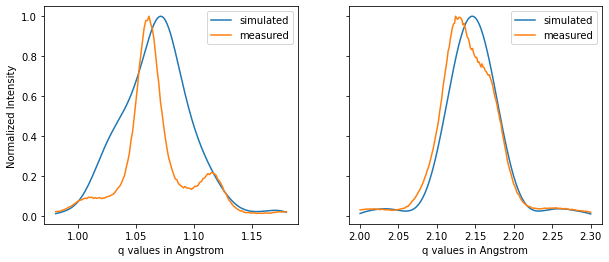

In [3]:
fig,ax = plt.subplots(1,len(multi_region),figsize = (5*len(multi_region),4),sharey = True)
i=0
if type(ax) != np.ndarray:
    ax = np.array([ax])
for qrange in multi_region:
    selection = experimental_pattern.data[(experimental_pattern.data.iloc[:,0]>qrange[0]) & (experimental_pattern.data.iloc[:,0]<qrange[1])]
    experimental_pattern.q_vals = selection.values[:,0]
    experimental_pattern.intens = selection.values[:,1]/max(selection.values[:,1])
    simulated = experimental_pattern.sim(None,[5.82,40,2,13,2,0.013]) # simulates the pattern with the given starting guess 
    ax[i].plot(experimental_pattern.q_vals,experimental_pattern.simulated,label = 'simulated') # plots the simulated data
    ax[i].plot(experimental_pattern.q_vals,experimental_pattern.intens, label = 'measured') # plots the measured data
    # add some labels & a lagend
    ax[i].set_xlabel('q values in Angstrom')
    ax[i].legend()
    i+=1                  
ax[0].set_ylabel('Normalized Intensity')
plt.show()

-----------------------------------------------------------------------------------------------------------
FITTING. 

Performs the fit with the settings specified above, and outputs fitting plot and best fit parameters.



(0.98, 1.18)
(2, 2.3)


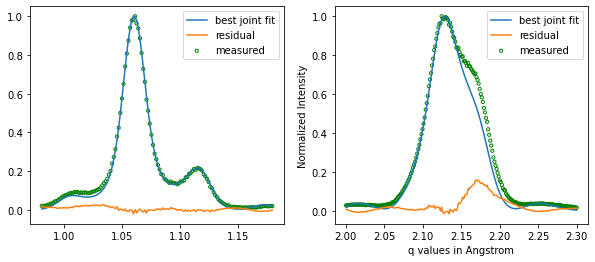

Fit Parameters: [5.8702, 35.8737, 1.0222, 12.9511, 1.1467, 0.0039]


In [4]:
fits = experimental_pattern.fit(multi_region, x0 = starting_guess,bounds = bounds,weights = weights_mr)
# Fits the model to the data in the object, given a q-range, starting point and bounds on the parameters
fig,ax = plt.subplots(1,len(multi_region),figsize = (10,4))
if type(ax) != np.ndarray:
    ax = np.array([ax])
for i in range(len(experimental_pattern.q_vals_list)):
    ax[i].plot(experimental_pattern.q_vals_list[i],experimental_pattern.sim_list[i],label = 'best joint fit')
    ax[i].scatter(experimental_pattern.q_vals_list[i],experimental_pattern.intens_list[i], label = 'measured',facecolors = 'none', edgecolor = 'g',s = 10)
    ax[i].plot(experimental_pattern.q_vals_list[i],experimental_pattern.intens_list[i] - experimental_pattern.sim_list[i], label = 'residual')
    ax[i].legend()
plt.xlabel('q values in Angstrom')
plt.ylabel('Normalized Intensity')
plt.legend()
plt.show()
print('Fit Parameters: ' + str([round(x,4) for x in experimental_pattern.x0]))

-----------------------------------------------------------------------------------------------------------
MEAN SQUARE ERROR MAPS.

Plots the Mean Square Error of the fit as a function of fit parameters. 

(0.98, 1.18)
(2, 2.3)


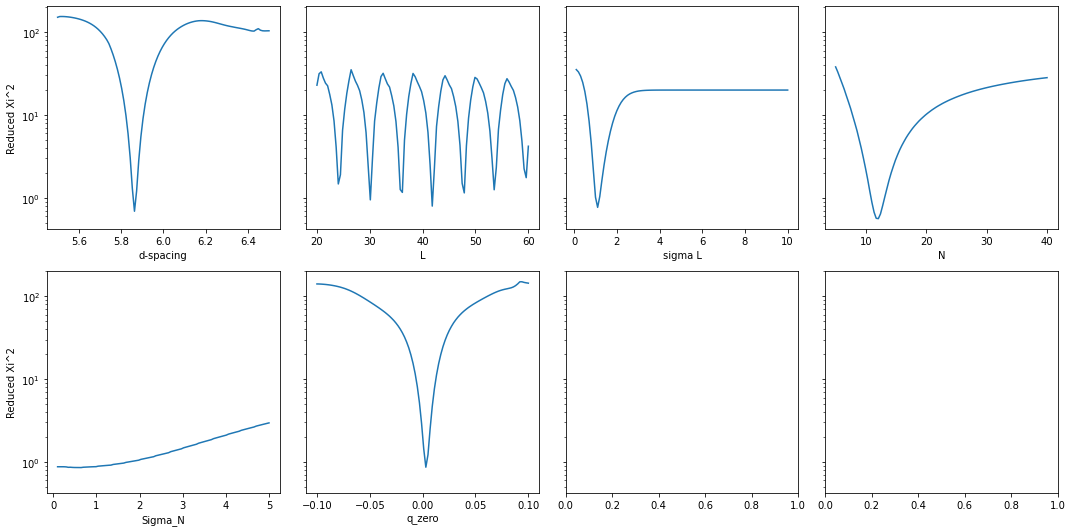

In [5]:
param_ranges = ([5.5,20,0.1,5,0.1,-0.1],[6.5,60,10,40,5,0.1])
# Set the plotting ranges for the Mean Square Error maps (one interval for each parameter)
# d, L, sigmaL, N, sigmaN, q_zero (optional), C (optional)

params,results = experimental_pattern.get_lin_uncertainties(param_ranges,q_ranges = multi_region,n_points = 100,err_kw = {'a': 0.0,'b' : 0.03})

param_names = ['d-spacing','L','sigma L','N', 'Sigma_N','q_zero','C']
fig,ax = plt.subplots(2,4,sharey = True,figsize = (15,7.5))
ax = [item for sublist in ax for item in sublist]
for i in range(len(params)):
    ax[i].plot(params[i],results[i])
    ax[i].set_yscale('log')
    #ax[i].set_ylim(0.001,0.5)
    if i%4 ==0:
        ax[i].set_ylabel('Reduced Xi^2')
    ax[i].set_xlabel(param_names[i])
fig.tight_layout()
plt.show()

-----------------------------------------------------------------------------------------------------------
ERROR BARS.

Uses a bootstrap algorithm to estimate error bars on the fit parameters. <br>It needs an estimation of the experimental intensity fluctuation as an input.


C:\Users\tosos\anaconda3\lib\site-packages\scipy\optimize\_lsq\common.py:115: RuntimeWarning: overflow encountered in power
  phi_prime = -np.sum(suf ** 2 / denom**3) / p_norm
C:\Users\tosos\anaconda3\lib\site-packages\scipy\optimize\_lsq\common.py:154: RuntimeWarning: invalid value encountered in double_scalars
  ratio = phi / phi_prime
C:\Users\tosos\anaconda3\lib\site-packages\scipy\optimize\_lsq\common.py:369: RuntimeWarning: invalid value encountered in greater_equal
  return np.all((x >= lb) & (x <= ub))
C:\Users\tosos\anaconda3\lib\site-packages\scipy\optimize\_lsq\common.py:369: RuntimeWarning: invalid value encountered in less_equal
  return np.all((x >= lb) & (x <= ub))
C:\Users\tosos\anaconda3\lib\site-packages\scipy\optimize\_lsq\common.py:398: RuntimeWarning: invalid value encountered in sign
  return min_step, np.equal(steps, min_step) * np.sign(s).astype(int)
C:\Users\tosos\anaconda3\lib\site-packages\scipy\optimize\_lsq\trf.py:363: RuntimeWarning: divide by zero encount

(100, 6)
d-spacing: 5.8701 ± 0.0021
L: 35.8666 ± 0.0586
sigma L: 1.0099 ± 0.0257
N: 12.9243 ± 0.2735
Sigma_N: 1.1712 ± 0.6644
q_zero: 0.0039 ± 0.0006


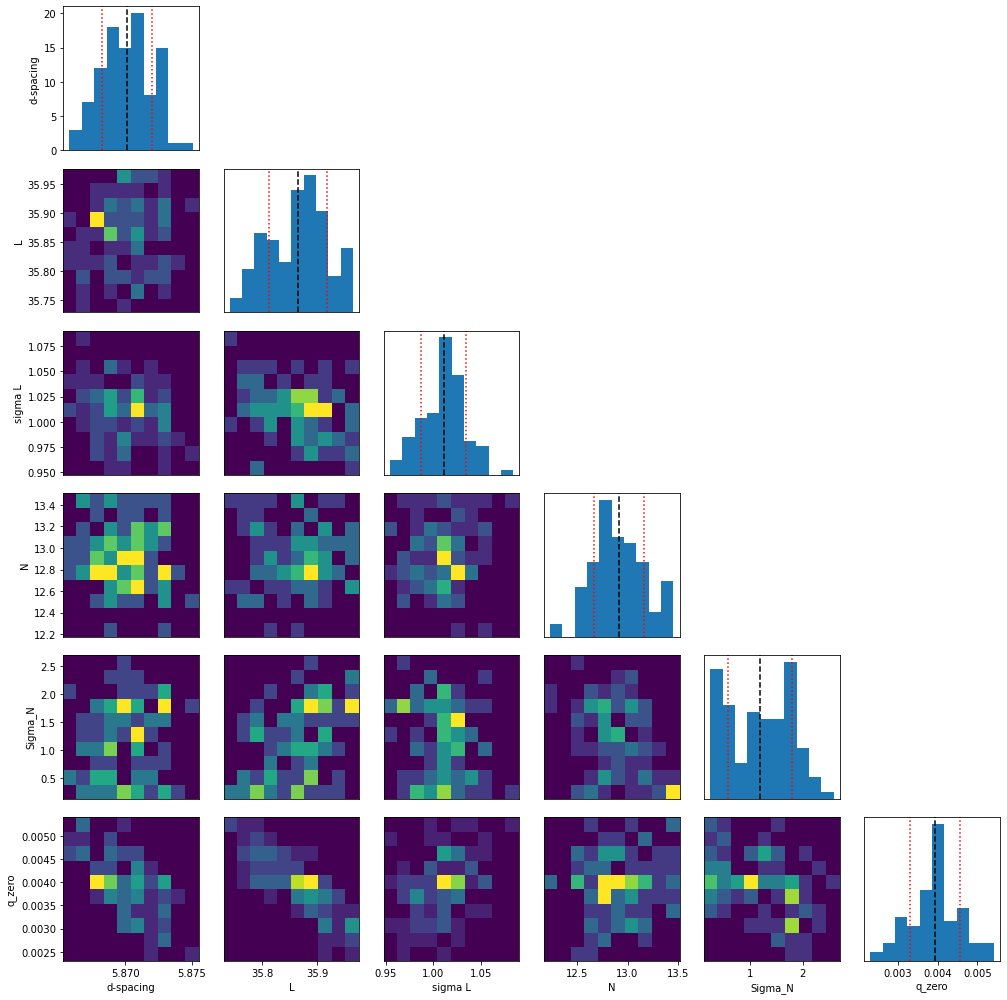

In [6]:
assumed_error = 0.03 # Insert an estimation of the experimental error on the intensities, e.g. 3%

bs_results = experimental_pattern.fit_bootstrap(multi_region,x0 = starting_guess,bounds = bounds, weights = weights_mr,err_kw = {'a' : 0.0, 'b' : assumed_error} )

bs_narray = np.array(bs_results)
param_values = bs_narray[:,0,:6]
print(param_values.shape)
param_avgs = []
param_stds = []
fig,ax = plt.subplots(6,6,figsize = (14,14))
labels =  ['d-spacing','L','sigma L','N', 'Sigma_N','q_zero']
for i in range(6):
    for j in range(6):
        if i==j:
            ax[i,j].hist(param_values[:,i])
            ax[i,j].axvline(np.average(param_values[:,i]),0,1,color='k',linestyle = '--')
            ax[i,j].axvline(np.average(param_values[:,i]) - np.std(param_values[:,i]),0,1,color='r',linestyle = ':')
            ax[i,j].axvline(np.average(param_values[:,i]) + np.std(param_values[:,i]),0,1,color='r',linestyle = ':')
            print(labels[i] + ': ' + str(round(np.average(param_values[:,i]),4)) + u" \u00B1 "  + str(round(np.std(param_values[:,i]),4)))
            param_avgs.append(np.average(param_values[:,i]))
            param_stds.append(np.std(param_values[:,i]))
        elif j<i:
            ax[i,j].hist2d(param_values[:,j],param_values[:,i])
        if i<5:
            ax[i,j].set_xticks([])
        else:
            ax[i,j].set_xlabel(labels[j])
        if j>0:
            ax[i,j].set_yticks([])
        else:
            ax[i,j].set_ylabel(labels[i])
        if j>i:
            fig.delaxes(ax[i,j])
            
fig.tight_layout()
plt.show()

-----------------------------------------------------------------------------------------------------------
OUTPUT.

Saves a simulated diffraction pattern. BE CAREFUL: the program overwrites the file at each run.

In [7]:
database = experimental_pattern.data
q_vals = database.iloc[:,0]
sims = experimental_pattern.sim(q_vals,param_avgs)
database['simulated'] = sims
database['residuals'] = database.iloc[:,1]/max(database.iloc[:,1]) - database['simulated']

database.to_csv('FIT_anneal_100.csv')
# Specify the output filename here
